# W5_Boosting a Decision Stump

In [1]:
import numpy as np
import pandas as pd
from math import log
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('lending-club-data.csv')
data['safe_loans'] = data['bad_loans'].apply(lambda x: 1 if x==0 else -1)
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
target = 'safe_loans'
data = pd.get_dummies(data[[target]+features])
data.head()

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,...,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_n/a
0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [3]:
train_index = list(pd.read_json('module-8-assignment-2-train-idx.json')[0])
test_index = list(pd.read_json('module-8-assignment-2-test-idx.json')[0])
train = data.iloc[train_index]
test = data.iloc[test_index]

In [4]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # weight of mistakes when all predictions are +1
    weighted_mistakes_all_positive = sum(data_weights[labels_in_node==-1])
    
    # weight of mistakes when all predictions are -1
    weighted_mistakes_all_negative = sum(data_weights[labels_in_node==1])
    
    if weighted_mistakes_all_positive <= weighted_mistakes_all_negative:
        # return(weighted mistakes, predicted label)
        return(weighted_mistakes_all_positive, 1)
    else:
        return(weighted_mistakes_all_negative, -1)

In [5]:
def best_splitting_feature(data, features, target, data_weights):
    best_feature = None
    best_error = float('inf')
    
    for feature in features:
        left_split = data[data[feature]==0]
        right_split = data[data[feature]==1]
        
        left_weights = data_weights[data[feature]==0]
        right_weights = data_weights[data[feature]==1]
        
        left_weighted_mistakes, left_label = intermediate_node_weighted_mistakes(left_split[target], left_weights)
        right_weighted_mistakes, right_label = intermediate_node_weighted_mistakes(right_split[target], right_weights)
        
        error = (left_weighted_mistakes+right_weighted_mistakes) / sum(data_weights)
        
        if error < best_error:
            best_feature = feature
            best_error = error
            
    return best_feature

In [6]:
def create_leaf(target_values, data_weights):
        leaf = {'splitting_feature' : None,
                'left' : None,
                'right' : None,
                'is_leaf': True}
        weighted_error, label = intermediate_node_weighted_mistakes(target_values, data_weights)
        leaf['prediction'] = label
        return leaf

In [7]:
def create_decision_tree(data, features, target, data_weights, current_depth=0, max_depth=10):
    remaining_features = features[:]
    target_values = data[target]
    
    #print('--------------------------------------------------------------------')
    #print('Subtree, current depth:{}, data point:{}'.format(current_depth, len(data)))
    
    # stopping condition 1
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        #print('Stopping condition reached: no mistake')
        return create_leaf(target_values, data_weights)
    
    # stopping condition 2
    if len(remaining_features) == 0:
        #print('Stopping condition reached: all features are used')
        return create_leaf(target_values, data_weights)
    
    # early stopping condition 1
    if current_depth == max_depth:
        #print('Stopping condition reached: maximum depth')
        return create_leaf(target_values, data_weights)

    splitting_feature = best_splitting_feature(data, remaining_features, target, data_weights)
    remaining_features.remove(splitting_feature)
    
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    #print('Splitting feature:{}, left split:{}, right split:{}'.format(best_splitting_feature, len(left_split), len(right_split)))
    
    if (len(left_split) == len(data) or len(right_split) == len(data)):
        #print('All feature values are the same. Create leaf node')
        return create_leaf(target_values, data_weights)
    
    left_tree = create_decision_tree(left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)  
    right_tree = create_decision_tree(right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)  
        
    return {'is_leaf': False, 
            'prediction': None,
            'splitting_feature': splitting_feature,
            'left': left_tree, 
            'right': right_tree}

In [8]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [9]:
def make_predicion(tree, x, annotate=False):
    if tree['is_leaf']:
        if annotate:
            print('reach leaf!')
        return tree['prediction']
    else:
        splitting_feature_value = x[tree['splitting_feature']]
        if annotate:
            print('splitting feature:{}, value:{}'.fotmat(tree['splitting_feature'], splitting_feature_value))
        if splitting_feature_value == 0:
            return make_predicion(tree['left'], x, annotate)
        else:
            return make_predicion(tree['right'], x, annotate)

In [10]:
def compute_classification_error(tree, data):
    predictions_list = []
    for i in range(len(data)):
        predictions_list.append(make_predicion(tree, data.iloc[i]))
    predictions = np.array(predictions_list)
    error_num = (predictions!=data['safe_loans']).sum()
    error_ratio = error_num / float(len(data))
    return error_ratio

In [11]:
# assign weights to only the first 10 and last 10 data points
ex_data_weights = np.array([1.]*10 + [0.]*(len(train)-20) + [1.]*10)
features = list(train.columns)
features.remove('safe_loans')
target = 'safe_loans'
ex_tree = create_decision_tree(train, features, target, ex_data_weights, max_depth=2)

In [12]:
print(compute_classification_error(ex_tree, train))
print(compute_classification_error(ex_tree, train.iloc[0:10].append(train.iloc[-10:])))

0.481248656781
0.05


In [13]:
def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.array([1.]*len(data))
    weights = []
    tree_stumps = []
    
    for t in range(num_tree_stumps):
        print('=====================================================')
        print ('Adaboost Iteration %d' % t)
        
        # learn a weighted decision tree stump. 
        # use max_depth=1
        tree_stump = create_decision_tree(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        predictions_list = []
        for i in range(len(data)):
            predictions_list.append(make_predicion(tree_stump, data.iloc[i]))
        predictions = np.array(predictions_list)
        
        # produce Boolean array indicating whether each data point is correctly classified
        is_correct = data[target] == predictions # array
        is_worng = data[target] != predictions

        # compute coefficient w hat for this tree stump       
        weighted_error = sum(alpha * is_worng)
        total_weights = sum(alpha)
        weighted_error = weighted_error / total_weights
        weight = (1/2) * log((1-weighted_error) / weighted_error)
        weights.append(weight)
        
        # recompute data weights alpha
        v_fun = np.vectorize(lambda x : exp(-weight) if x else exp(weight))
        adjustment = v_fun(is_correct)
        alpha = alpha * adjustment
        alpha = alpha / sum(alpha) # normalize data points weights
        
    return weights, tree_stumps

In [14]:
weights_10, tree_stumps_10  = adaboost_with_tree_stumps(train, features, target, 10)

Adaboost Iteration 0
Adaboost Iteration 1
Adaboost Iteration 2
Adaboost Iteration 3
Adaboost Iteration 4
Adaboost Iteration 5
Adaboost Iteration 6
Adaboost Iteration 7
Adaboost Iteration 8
Adaboost Iteration 9


In [15]:
weights_10

[0.15802933659263743,
 0.1768236329364191,
 0.09311888971129693,
 0.07288885525840554,
 0.06706306914118143,
 0.06456916961644447,
 0.05456055779178564,
 0.04351093673362621,
 0.02898871150041245,
 0.02596250969152032]

In [16]:
def make_adaboost_prediction(stump_weights, tree_stumps, data):
    scores= np.array([0.]*len(data))
    
    for t, tree_stump in enumerate(tree_stumps):
        predictions_list = []
        for i in range(len(data)):
            predictions_list.append(make_predicion(tree_stump, data.iloc[i]))
        predictions = np.array(predictions_list)
        scores += stump_weights[t] * predictions

    v_fun = np.vectorize(lambda x : +1 if x > 0 else -1)
    return v_fun(scores)

In [17]:
weights_30, tree_stumps_30  = adaboost_with_tree_stumps(train, features, target, 30)

Adaboost Iteration 0
Adaboost Iteration 1
Adaboost Iteration 2
Adaboost Iteration 3
Adaboost Iteration 4
Adaboost Iteration 5
Adaboost Iteration 6
Adaboost Iteration 7
Adaboost Iteration 8
Adaboost Iteration 9
Adaboost Iteration 10
Adaboost Iteration 11
Adaboost Iteration 12
Adaboost Iteration 13
Adaboost Iteration 14
Adaboost Iteration 15
Adaboost Iteration 16
Adaboost Iteration 17
Adaboost Iteration 18
Adaboost Iteration 19
Adaboost Iteration 20
Adaboost Iteration 21
Adaboost Iteration 22
Adaboost Iteration 23
Adaboost Iteration 24
Adaboost Iteration 25
Adaboost Iteration 26
Adaboost Iteration 27
Adaboost Iteration 28
Adaboost Iteration 29


In [18]:
# compute training error at the end of each iteration
training_error_list = []
for t in range(1,31):
    predictions = make_adaboost_prediction(weights_30[:t], tree_stumps_30[:t], train)
    error_num = (predictions!=train['safe_loans']).sum()
    error_ratio = error_num / float(len(train))
    training_error_list.append(error_ratio)
    print('Iteration:{}, error:{}'.format(t, training_error_list[t-1]))    

Iteration:1, error:0.4216365785514722
Iteration:2, error:0.4334300451321728
Iteration:3, error:0.40003761014399314
Iteration:4, error:0.40003761014399314
Iteration:5, error:0.3847249086610789
Iteration:6, error:0.38461745110681284
Iteration:7, error:0.3827638082957232
Iteration:8, error:0.38461745110681284
Iteration:9, error:0.3827638082957232
Iteration:10, error:0.38448312916398025
Iteration:11, error:0.3827369439071567
Iteration:12, error:0.3814474532559639
Iteration:13, error:0.38152804642166344
Iteration:14, error:0.3805609284332689
Iteration:15, error:0.38050719965613583
Iteration:16, error:0.3782237266279819
Iteration:17, error:0.378277455405115
Iteration:18, error:0.37841177734794756
Iteration:19, error:0.37806254029658287
Iteration:20, error:0.37876101439931226
Iteration:21, error:0.37956694605630775
Iteration:22, error:0.37889533634214484
Iteration:23, error:0.37889533634214484
Iteration:24, error:0.37876101439931226
Iteration:25, error:0.37889533634214484
Iteration:26, error:

In [19]:
# compute test error at the end of each iteration
test_error_list = []
for t in range(1,31):
    predictions = make_adaboost_prediction(weights_30[:t], tree_stumps_30[:t], test)
    error_num = (predictions!=test['safe_loans']).sum()
    error_ratio = error_num / float(len(test))
    test_error_list.append(error_ratio)
    print('Iteration:{}, error:{}'.format(t, test_error_list[t-1])) 

Iteration:1, error:0.4233089185695821
Iteration:2, error:0.42847910383455406
Iteration:3, error:0.3981042654028436
Iteration:4, error:0.3981042654028436
Iteration:5, error:0.3799009047824214
Iteration:6, error:0.38000861697544164
Iteration:7, error:0.3792546316242999
Iteration:8, error:0.38000861697544164
Iteration:9, error:0.3792546316242999
Iteration:10, error:0.3796854803963809
Iteration:11, error:0.3792546316242999
Iteration:12, error:0.37796208530805686
Iteration:13, error:0.3792546316242999
Iteration:14, error:0.3778543731150366
Iteration:15, error:0.3785006462731581
Iteration:16, error:0.3778543731150366
Iteration:17, error:0.37796208530805686
Iteration:18, error:0.3778543731150366
Iteration:19, error:0.37817750969409736
Iteration:20, error:0.3768849633778544
Iteration:21, error:0.37753123653597587
Iteration:22, error:0.3767772511848341
Iteration:23, error:0.3767772511848341
Iteration:24, error:0.3768849633778544
Iteration:25, error:0.3767772511848341
Iteration:26, error:0.37656

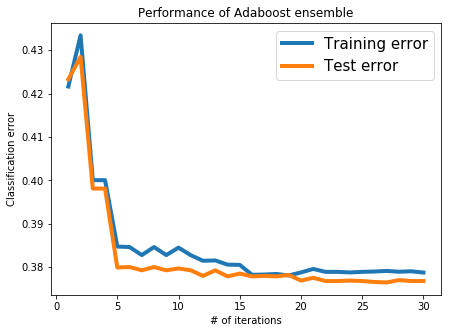

In [20]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), training_error_list, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_list, '-', linewidth=4.0, label='Test error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})